In [1]:
""" sheet1_implementation.py

PUT YOUR NAME HERE:
Boris Bubla
Leonard Paeleke


Write the functions
- pca
- gammaidx
- lle
Write your implementations in the given functions stubs!


(c) Daniel Bartz, TU Berlin, 2013
"""


' sheet1_implementation.py\n\nPUT YOUR NAME HERE:\nBoris Bubla\nLeonard Paeleke\n\n\nWrite the functions\n- pca\n- gammaidx\n- lle\nWrite your implementations in the given functions stubs!\n\n\n(c) Daniel Bartz, TU Berlin, 2013\n'

In [2]:
import os
import numpy as np
import scipy.linalg as la
import scipy.spatial as sp
import matplotlib.pyplot as plt
from scipy.linalg import expm
import matplotlib.gridspec as gridspec
import scipy.io as sio

In [3]:
class PCA():
    """
        Definition of PCA Class
        Algorithms in guide.pdf used, pg 15-17
    """
    def __init__(self, Xtrain):
        """
            Compute Principal Components
        """
        # 1. centre data
        self.Xmean = np.mean(Xtrain, axis = 0)
        self.C = Xtrain - self.Xmean
        # 2. generate covariance marix
        self.C = np.cov(self.C, rowvar=False)
        # 3. calculate eigenvalues and eigenvectors
        self.D, self.U = np.linalg.eigh(self.C)
        
        self.idx = np.argsort(self.D)[::-1]
        # Sort the eigenvalue from high to low
        self.D = self.D[self.idx]
        # sort eigenvectors according to same index
        self.U = self.U[:,self.idx]
       
    def project(self, Xtest, m):
        """
            Projecting to the low-dimensional sub-space
        """
        # 1. centre data by mean of training
        Xtest = Xtest - self.Xmean
        # 2. project data to m principal components
        Z = self.U.T[range(m)].dot(Xtest.T).T    
        return Z
    
    def denoise(self, Xtest, m):
        """
            Reconstructing projected data points in the original space
        """
        # 1. projection to the low-dimencsional sub-space
        Z = self.project(Xtest, m)
        # 2. recontruction by m dimensions
        Y = Z.dot(self.U.T[range(m)])+self.Xmean
        return Y

In [4]:
def gammaidx(X, k):
    """
    Gamma identification for outlier detection by ranking
    """
    y = []
    # Calculate distance matrix
    # D = sp.distance_matrix(X, X) # forbidden
    
    z = np.array([complex(c[0], c[1]) for c in X])
    m, n = np.meshgrid(z, z) # just working for 2 D data?
    # get the distance via the norm
    D = np.linalg.norm(m-n)
    
    # D = np.sqrt(np.sum((X[None, :] - X[:, None])**2, -1)) # ToDO Boris said it's not working 
    
    # Sort distance matrix
    kn = np.argsort(D,kind='mergesort')
    # identify k-nearest neighbours
    kn = kn[:,1:k+1]
    # sum over k-neaest neighbours and divide bei k
    y = np.sum(np.take_along_axis(D, kn, axis = 1),axis = 1)/k
    
    return y

In [5]:
y = gammaidx(X, k)

NameError: name 'X' is not defined

In [ ]:
y

In [ ]:
correct_gamma = np.array([ 0.606051220224367, 1.61505686776722, 0.480161964450438, 1.18975154873627,
                                    2.93910520141032, 2.15531724762712, 0.393996268071324, 0.30516080506303,
                                    0.787481421847747, 0.895402545799062, 0.385599174039363, 0.544395897115756,
                                    0.73397995201338, 0.314642851266896, 0.376994725474732, 0.501091387197748,
                                    1.3579045507961, 1.96372676400505, 0.389228251829715, 0.910065898315003])

In [ ]:
pos_label = 1
y_true = test1_y_true
y_pred = test1_y_pred

In [6]:
def auc(y_true,y_pred,plot=False):
    #1. FIND ROC CURVE POINTS & FPR/TPR
    pos_label=1
    y_true=(y_true==pos_label) #boolean vec of true labels

    #arrange predictions in descending order (indexes)
    descending_scores=np.argsort(y_pred,kind='mergesort')[::-1]
    #ascending_scores=np.argsort(y_pred,kind='mergesort')[::1]
    y_pred=y_pred[descending_scores]
    y_true=y_true[descending_scores]

    #determine distinct values to create an index of decreasing values
    #'predicted value in y_pred where lower values tend to correspond to label -1 and higher values to label +1'
    distinct_values_idx=np.where(np.diff(y_pred))[0]#length n-1 as calculating differences
    distinct_descending_scores_idx=np.r_[distinct_values_idx,y_true.size-1]# add last entry

    tps=np.cumsum(y_true)[distinct_descending_scores_idx]#cumulative sum of true positives using idx
    fps=1-tps+distinct_descending_scores_idx #same as cum sum of false positives

    #add 0,0 position for ROC curve
    tps=np.r_[0,tps]
    fps=np.r_[0,fps]

    #false/true positive rate
    fpr=fps/fps[-1] #rate=sum/max
    tpr=tps/tps[-1]
    
    #2.PLOT ROC CURVE POINTS
    if plot==True:
        plt.plot(fpr,tpr,label='Algorithm')
        plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),label='Random guesses')
        plt.ylabel('True Positive Rate (TPR)')
        plt.xlabel('False Positive Rate (FPR)')
        plt.title('ROC Curve')
        plt.legend()

    #3. CALCULATE AUC
    #reshape needed
    fpr=fpr.reshape(1,fpr.shape[0])
    tpr=tpr.reshape(1,tpr.shape[0])
    
    #assume positive area
    end=1
    #check if negative area (good discrimination, just switch labels)
    diff_fpr=np.diff(fpr)
    if np.all(diff_fpr<=0):
        end=-1
    #calculate area using trapezoidal approach
    area=end*np.trapz(tpr,fpr)

    return area

In [ ]:
test1_y_true=np.array([-1, -1, -1, +1, +1])
test1_y_pred=np.array([0.3, 0.4, 0.5, 0.6, 0.7])#ans=1.0
test2_y_true=np.array([-1, -1, -1, +1, +1, +1])
test2_y_pred=np.array([0.3, 0.4, 0.6, 0.5, 0.7, 0.8])#ans=0.89
test3_y_true=np.array([+1, -1, -1, +1, +1, -1])
test3_y_pred=np.array([0.3, 0.4, 0.6, 0.5, 0.7, 0.8])#ans=1/3

In [ ]:
auc(test1_y_true,test1_y_pred,plot=True)

In [ ]:
auc(test2_y_true,test2_y_pred,plot=True)

In [ ]:
auc(test3_y_true,test3_y_pred,plot=False)

In [43]:
from scipy.sparse.csgraph import connected_components

def lle(X, m, tol, n_rule, k=None, epsilon=None):
    """
        Locally Linear Embedding
    """
    
    # compute neighborhoord by kNN or eps-bole rule
    
    # 1. calculate euclidean distance of data
    D = np.sqrt(np.sum((X[None, :] - X[:, None])**2, -1))
    
    # 2. check for applied rule
    if n_rule == 'knn':
        # check if k is provided
        assert (k != None), """The parameter 'k' is required for the 'knn' rule"""
        # 3a. calculate k nearest neighbors
        # Sort distance matrix
        kn = np.argsort(D,kind='mergesort')
        # identify k-nearest neighbors
        kn = kn[:,1:k+1]
        
    elif n_rule == 'eps-ball':
        # check if epsilon is provided
        assert (epsilon != None), """The parameter 'epsilon' is required for the 'eps-ball' rule"""
        # 3b. compare distance by epsilon
        # tupel (1. element, 2. element)
        #idx = np.argwhere(D<epsilon)
        # row wise all points in the neighborhood
        #kn = [idx[:,1][idx[:,0]==i] for i in np.unique(idx[:,0])]
        
        # 3b. compare distance by epsilon
        #boolean approach
        kn=D<epsilon
    else:
        print("""The following rule {} is not known. Please use either 'knn' or 'eps-ball'.""".format(n_rule))
    
    # 4. calculate reconstruction weights 
    # intialize weight matrix
    W = np.zeros((len(X),len(X)))
    # calculate weights for every point
    for i in range(len(X)):
        # calculate covariance matrix
        C = np.cov(X[i]-X[kn[i]])
        # solve for weights 
        I = np.eye(len(X[kn[i]]))
        weights = np.linalg.inv(C-tol*I).dot(np.ones(len(X[kn[i]])).reshape(len(X[kn[i]]),1))
        # normalize weights
        weights = (1/(weights.T.dot(np.ones(len(X[kn[i]])).reshape(len(X[kn[i]]),1)))*weights).reshape(len(X[kn[i]]))
        W[i,kn[i]] = weights
    
    # 5. calculate cost matrix
    I = np.eye(len(X))
    M = (I - W).T@(I-W)
    
    # 6. Obtain eigenvalues and eigenvector of M
    eigen_values, eigen_vector = np.linalg.eigh(M)
    # sort eigenvalues in ascending order
    eigen_kn = np.argsort(abs(eigen_values),kind='mergesort').reshape(len(X),1)
    # sort eigenvectors by eigenvalues, eigenvector along columns, first eigenvector -> [:,0]
    V = -1*np.take_along_axis(eigen_vector.T, eigen_kn, axis = 0).T # CAVEAT: mulitplying by -1 because numpy.eig routine delivers wrong sign
    
    # 7. embedded dimension 
    Y = V[:,1:m+1]
    
    #8 Check connected graphs
    if (connected_components(V,directed=False)[0]!=1):
        raise ValueError('Graphs are not connected!')
        
    return Y

In [ ]:
V = lle(X,5,0.05,'eps-ball',epsilon = 3)

In [ ]:
V.shape

In [ ]:
V

In [ ]:
kn = np.argsort(abs(eigen_values),kind='mergesort').reshape(len(X),1)
# identify k-nearest neighbours
#kn = kn[:,1:k+1]
# sum over k-neaest neighbours and divide bei k
y = np.take_along_axis(eigen_vector.T, kn, axis = 0).T

In [ ]:
# Test set for lle
def randrot(d):
    '''generate random orthogonal matrix'''
    M = 100. * (np.random.rand(d, d) - 0.5)
    M = 0.5 * (M - M.T);
    R = expm(M);
    return R

def test_lle():
    n = 500
    Xt = 10. * np.random.rand(n, 2);
    X = np.append(Xt, 0.5 * np.random.randn(n, 8), 1);

    # Rotate data randomly.
    X = np.dot(X, randrot(10).T)
    return X

In [ ]:
# ASSIGNMENT 5

In [8]:
# Load data
cwd = os.getcwd()
file_name = 'usps.mat'
path_to_data = cwd + '/data/'+file_name
assert os.path.exists(path_to_data), "The path does not excist."

data = sio.loadmat(path_to_data)

data_labels = data['data_labels']
data_patterns = data['data_patterns']

In [9]:
# Plot function for 2 b
def plot_fun(pca):
    """
    Plot function for Assignment 5
    Arranges the prinicple components plots
    """
    # intialize figure environment
    fig = plt.figure(figsize=(14, 8))
    gs = fig.add_gridspec(5, 3)
    
    # first plot: all principle components
    f_ax1 = fig.add_subplot(gs[:, 0])
    plt.bar(range(len(pca.D)),pca.D)
    plt.xticks(range(0, len(pca.D), 50), np.append(1,np.arange(50, len(pca.D), 50)))
    plt.title('all principle components')
    
    # second plot: first 25 principle components
    fig.add_subplot(gs[:, 1])
    plt.bar(range(25),pca.D[:25])
    plt.title('first 25 principle components')
    plt.xticks(range(0, 25, 6), range(1,26,6))


    # third plot: visualize first 5 principle components
    for i in range(5):
        f_ax3 = fig.add_subplot(gs[i, 2])
        if i == 0:
            f_ax3.set_title('first 5 components')
        plt.imshow(pca.U[i].reshape(16,16), cmap = 'gray')

    plt.show()

In [10]:
# perform pca
pca = PCA(data_patterns.T)

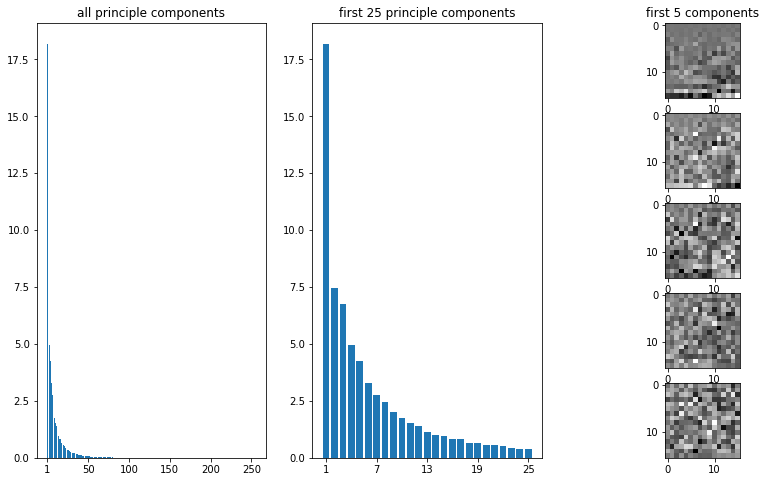

In [11]:
plot_fun(pca)

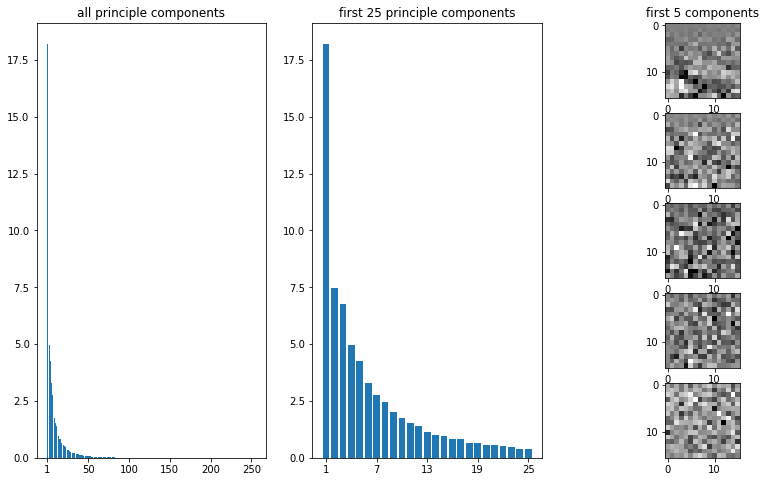

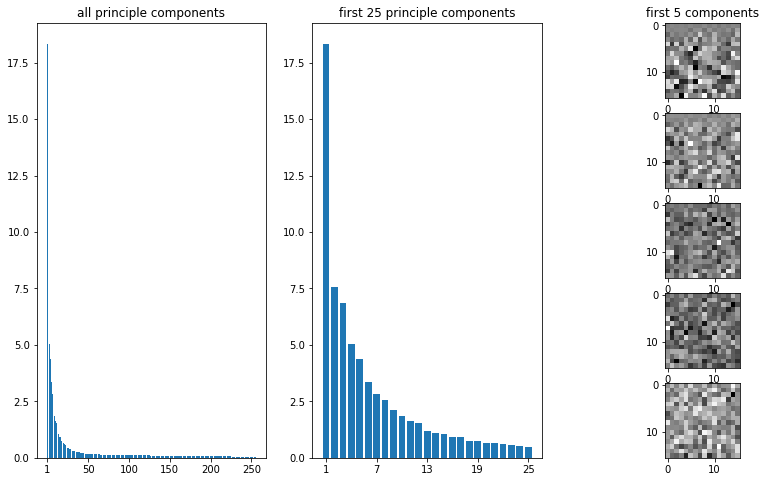

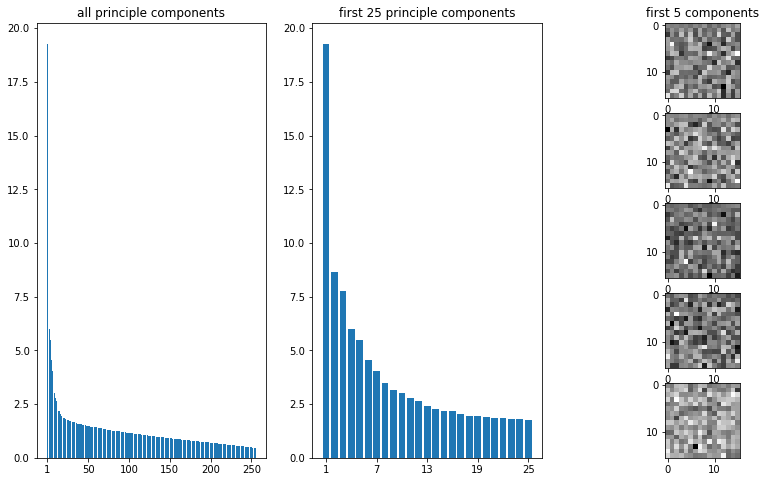

In [12]:
# Plot 3a).
# generate noisy data
sigmas = [0.05, 0.3, 1]
length, width= data_patterns.T.shape
counter = 1
#sigmas = [1]
for sigma in sigmas:
    
    data_patterns_noisy = np.copy(data_patterns.T) # prevent same disk space of variables
    # principle component evaluation
    if counter !=3:
        # noisy data
        length, width = data_patterns.T.shape
        data_patterns_noisy = sigma * np.random.randn(length, width) + data_patterns_noisy
    else:
        # outlier data
        pics = [0,1,2,13,34]
        length, width = data_patterns_noisy[[0,1,2,13,34]].shape
        # add gaussian noise to only 5 data points
        data_patterns_noisy[[0,1,2,13,34]] = sigma * np.random.randn(length, width) + data_patterns_noisy[[0,1,2,13,34]]
    
    pca_noise = PCA(data_patterns_noisy)
    plot_fun(pca_noise)
    
    # reconstruction by m principle components
    data_patterns_pjt = pca_noise.denoise(data_patterns_noisy,13)
    #img_num = 0
    #plt.figure(figsize=(14, 8))
    #plt.subplot(1,2,1)
    #plt.imshow(data_patterns_pjt[img_num].reshape(16,16))#,cmap = 'gray')
    #plt.subplot(1,2,2)
    #plt.imshow(data_patterns_noisy[img_num].reshape(16,16))#, cmap = 'gray')

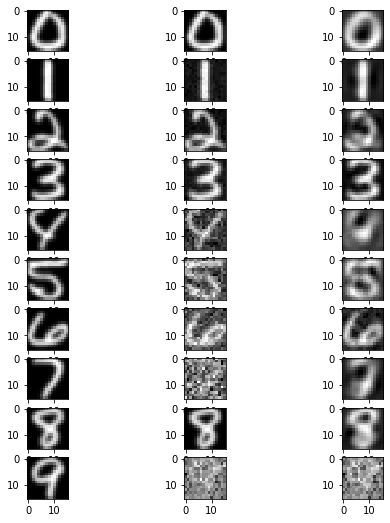

In [13]:
# 3b/c).
# generate noisy data
sigmas = [0, 0.05, 0.05, 0.05, 0.3, 0.3, 0.3, 1, 1, 1]
img_num = [5, 69, 68, 2, 13, 121, 1, 34, 70, 0] # 0 - 9
m = [7, 7, 25, 50, 7, 25, 50, 7, 25, 50]
length, width= data_patterns.T.shape

fig = plt.figure(figsize=(8, 9))
gs = fig.add_gridspec(10, 3)
for idx, sigma in enumerate(sigmas):
    
    data_patterns_noisy = np.copy(data_patterns.T) # prevent same disk space of variables
    # principle component evaluation
    if sigma !=1:
        # noisy data
        length, width = data_patterns.T.shape
        data_patterns_noisy = sigma * np.random.randn(length, width) + data_patterns_noisy
    else:
        # outlier data
        pics = [0,1,2,13,34]
        length, width = data_patterns_noisy[[0,1,2,13,34]].shape
        # add gaussian noise to only 5 data points
        data_patterns_noisy[[0,1,2,13,34]] = sigma * np.random.randn(length, width) + data_patterns_noisy[[0,1,2,13,34]]
    
    pca_noise = PCA(data_patterns_noisy)
    #plot_fun(pca_noise)
    
    # reconstruction by m principle components
    data_patterns_pjt = pca_noise.denoise(data_patterns_noisy,m[idx])
    #img_num = 0
    f_ax1 = fig.add_subplot(gs[idx, 0])
    plt.imshow(data_patterns.T[img_num[idx]].reshape(16,16), cmap = 'gray')
    f_ax1 = fig.add_subplot(gs[idx, 1])
    plt.imshow(data_patterns_noisy[img_num[idx]].reshape(16,16), cmap = 'gray')
    f_ax1 = fig.add_subplot(gs[idx, 2])
    plt.imshow(data_patterns_pjt[img_num[idx]].reshape(16,16),cmap = 'gray')

In [14]:
#ASSIGNMENT 6

In [15]:
#using old gammaidx function since it's stable -- the norm version threw an error.
def gammaidx(X, k):
    """
    Gamma identification for outlier detection by ranking
    """
    y = []
    # Calculate distance matrix
    D = sp.distance_matrix(X, X)
    # Sort distance matrix
    kn = np.argsort(D,kind='mergesort')
    # identify k-nearest neighbours
    kn = kn[:,1:k+1]
    # sum over k-neaest neighbours and divide bei k
    y = np.sum(np.take_along_axis(D, kn, axis = 1),axis = 1)/k
    
    return y

In [16]:
cwd = os.getcwd()
file_name = 'banana.npz'
path_to_data = cwd + '/data/'+file_name
assert os.path.exists(path_to_data), "The path does not excist."

#load and unpack data
data = np.load(path_to_data)
lst = data.files
for item in lst:
    print(item)
    print(data[item])

data
[[-3.0898387  -2.9808342  -2.8360574  ...  2.7103145   2.7544469
   2.8133603 ]
 [-0.83168647 -0.15957534 -0.17708113 ...  1.3465977   1.4719528
   1.3016674 ]]
label
[[-1. -1. -1. ...  1.  1.  1.]]


In [17]:
#data manipulation and preprocessing
outlier_rate=np.array([0.01,0.1,0.5,1])
pos_idx=np.argwhere(data['label']==1).T[1]#idx of pos class
n_outliers=np.round(outlier_rate*len(pos_idx))
pos_data=data['data'].T[pos_idx]
n_outliers=n_outliers.astype(int)

In [18]:
#This takes about 25min to run --- inefficient but gets the job done.
loops=50

results_3=np.empty((loops,len(n_outliers)))
results_10=np.empty((loops,len(n_outliers)))
results_mean=np.empty((loops,len(n_outliers)))

for i in range(loops):
    
    
    for j in n_outliers:
        
        #draw outliers from uniform box
        outliers=np.random.uniform(low=-4,high=4,size=(j,2))
        print(outliers[0][0])
        
        #reset data
        data_=data['data'].T
        labels_=data['label'].T
        #print(data_.shape)
        #print(labels_.shape)
        
        #add outliers to positive class
        data_=np.append(data_,outliers,axis=0)
        labels_=np.append(labels_,np.ones((j,1)),axis=0)
        
        #print(data_.shape)
        #print(labels_.shape)
        
        #compute gamma 3,10,mean
        gamma_3=gammaidx(data_,3)
        gamma_10=gammaidx(data_,10)
        #compute dist_to_mean
        diff=np.subtract(data_,np.mean(data_,axis=0))
        dist_to_mean=np.linalg.norm(diff,axis=1)
        
        #print("gamma_3",gamma_3)
        #print("gamma10",gamma_10)
        #print("dist_to_mean",dist_to_mean)
        
        #compute auc
        auc_3=auc(labels_,gamma_3)
        auc_10=auc(labels_,gamma_10)
        auc_mean=auc(labels_,dist_to_mean)
        
        #print("auc 3",auc_3)
        #print("auc 10",auc_10)
        #print("auc mean",auc_mean)
        
        #store results
        results_3[i][np.argwhere(n_outliers==j)]=auc_3[0]
        results_10[i][np.argwhere(n_outliers==j)]=auc_10[0]
        results_mean[i][np.argwhere(n_outliers==j)]=auc_mean[0]
        
        
        

0.4357987213719907
-3.2533646220448373
-2.9021225598942113
-1.413766298604327
-2.3178657363402495
-1.4081128098146065
3.6891017618632267
3.7791201008447945
-3.014397790578654
-2.48435131878941
1.7882294140011759
-1.4475282868765316
-1.5068863499239775
-2.00649639922404
-0.6978327203295782
-0.8914205702349891
3.5852816973289263
-0.9023576900354575
-3.1077580284060033
-3.2216343233917817
-0.6090957277879854
-2.0172137520721227
0.1352201601149492
-2.0128441636692704
-1.2044284205539055
-1.6419770088720096
-1.059232051148948
-3.146604179498322
-1.1918569719885772
3.33045809220234
0.7480758050492522
1.1435735062564172
0.29986971850886945
0.5904862538347082
2.9573260376162214
-2.958023483048353
1.4689755847834078
-0.3431695325311521
0.3246398805586761
1.2082226889856438
-3.9423562662597122
-3.247712477156263
2.8107731783650065
-0.9168281631881872
-3.6625825686621987
3.491565580969917
1.6679657320032666
-0.2449575496549885
2.973008617718132
3.663908323871423
-1.65636099915059
-3.7839735060318

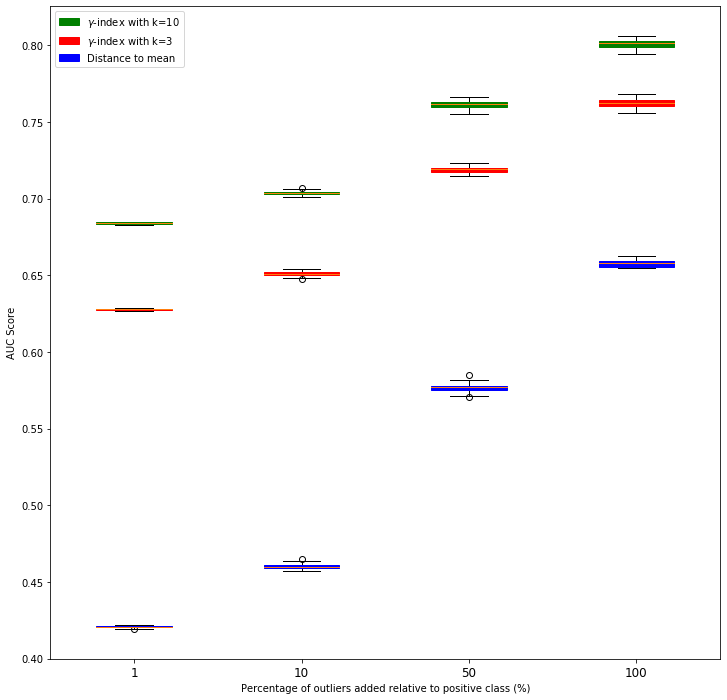

In [19]:
#plot the results
fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlabel('Percentage of outliers added relative to positive class (%)')
ax.set_ylabel('AUC Score')
bp1=ax.boxplot(results_10,patch_artist=True,boxprops=dict(facecolor='green', color='green'))
bp2=ax.boxplot(results_3,patch_artist=True,boxprops=dict(facecolor='red', color='red'))
bp3=ax.boxplot(results_mean,patch_artist=True,boxprops=dict(facecolor='blue', color='blue'))
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['1', '10', '50', '100'], fontsize=12)
ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['$\gamma$-index with k=10', '$\gamma$-index with k=3','Distance to mean'], loc='upper left')


In [32]:
#exemplary run
n_outliers=np.array([1188])#50% contamination

#draw outliers from uniform box
outliers=np.random.uniform(low=-4,high=4,size=(n_outliers[0],2))
        
#pos data
pos=data['data'].T
        
#add outliers to positive class
data_=np.append(pos,outliers,axis=0)
        
#compute gamma 3,10,mean
gamma_3=gammaidx(data_,3)
gamma_10=gammaidx(data_,10)
#compute dist_to_mean
diff=np.subtract(data_,np.mean(data_,axis=0))
dist_to_mean=np.linalg.norm(diff,axis=1)

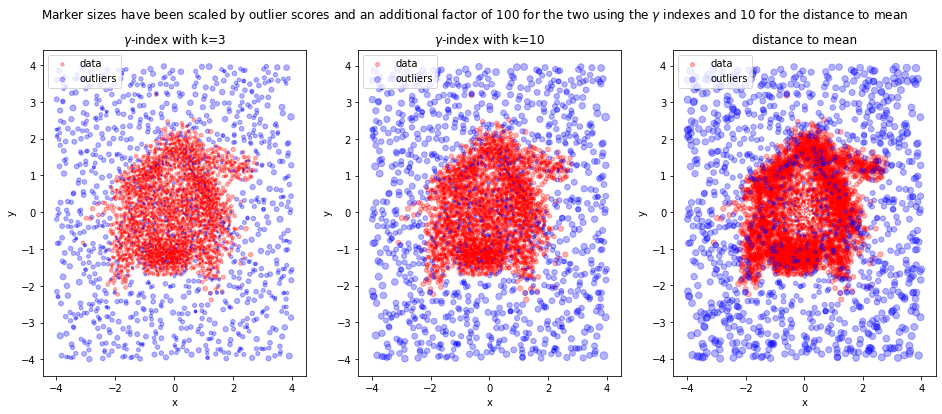

In [21]:
#exemplary plots
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16,6))
fig.suptitle('Marker sizes have been scaled by outlier scores and an additional factor of 100 for the two using the $\gamma$ indexes and 10 for the distance to mean', fontsize=12)

axes[0].scatter(x=pos.T[0],y=pos.T[1],s=gamma_3[:5300]*100,c='r',label='data',alpha=0.3,edgecolors=None,)
axes[0].scatter(x=outliers.T[0],y=outliers.T[1],s=gamma_3[5300:]*100,c='b',label='outliers',alpha=0.3,edgecolors=None)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('$\gamma$-index with k=3')
axes[0].legend()

axes[1].scatter(x=pos.T[0],y=pos.T[1],s=gamma_10[:5300]*100,c='r',label='data',alpha=0.3,edgecolors=None,)
axes[1].scatter(x=outliers.T[0],y=outliers.T[1],s=gamma_10[5300:]*100,c='b',label='outliers',alpha=0.3,edgecolors=None)
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('$\gamma$-index with k=10')
axes[1].legend()

axes[2].scatter(x=pos.T[0],y=pos.T[1],s=dist_to_mean[:5300]*10,c='r',label='data',alpha=0.3,edgecolors=None,)
axes[2].scatter(x=outliers.T[0],y=outliers.T[1],s=dist_to_mean[5300:]*10,c='b',label='outliers',alpha=0.3,edgecolors=None)
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
axes[2].set_title('distance to mean')
axes[2].legend()


In [ ]:
#ASSIGNMENT 7

In [36]:
#load data
cwd = os.getcwd()
file_name = 'fishbowl_dense.npz'
path_to_data = cwd + '/data/'+file_name
assert os.path.exists(path_to_data), "The path does not excist."
fishbowl = np.load(path_to_data)

cwd = os.getcwd()
file_name = 'swissroll_data.npz'
path_to_data = cwd + '/data/'+file_name
assert os.path.exists(path_to_data), "The path does not excist."
swissroll = np.load(path_to_data)

cwd = os.getcwd()
file_name = 'flatroll_data.npz'
path_to_data = cwd + '/data/'+file_name
assert os.path.exists(path_to_data), "The path does not excist."
flatroll = np.load(path_to_data)

In [37]:
lst = swissroll.files
for item in lst:
    print(item)
    print(swissroll[item])

el
[[13]]
noise
[[0]]
e
[[-0.43256481  0.28767642  1.1891642  ...  1.04768883  0.66001034
   0.85957298]
 [-1.66558438 -1.14647135 -0.03763328 ...  0.8633273   1.29411577
   0.12867004]
 [ 0.12533231  1.19091547  0.32729236 ... -0.6424113   0.31457906
   0.01656787]]
name
['classic swiss roll']
distances
[[ 0.         21.60802636 12.90216648 ...  5.55571702 22.7527932
  20.05344852]
 [21.60802636  0.         20.70207456 ... 22.88636566 16.42299685
  18.70850426]
 [12.90216648 20.70207456  0.         ... 16.08956392 12.71785254
   8.74591981]
 ...
 [ 5.55571702 22.88636566 16.08956392 ...  0.         24.59041972
  22.1352497 ]
 [22.7527932  16.42299685 12.71785254 ... 24.59041972  0.
   4.5782703 ]
 [20.05344852 18.70850426  8.74591981 ... 22.1352497   4.5782703
   0.        ]]
z
[[12.0963502   8.86094926 11.54188751  7.44369904 10.88317279  8.94190588
  11.82947522  4.80286193 11.95818686  7.00829826  3.68720535 10.80550634
   4.45060838  5.01450095  5.70690341  3.28554602  7.3365277  

In [38]:
#format data and references
fishbowl_data=fishbowl['X'].T
fishbowl_ref=fishbowl['X'].T[:,2]
swissroll_data=swissroll['x_noisefree'].T
swissroll_ref=swissroll['z'].T[:,0]
flatroll_data=flatroll['Xflat'].T
flatroll_ref=flatroll['true_embedding'].T

In [165]:
#FISHBOWL
#apply lle
fishbowl_lle=lle(fishbowl_data,2,0.00001,'eps-ball',epsilon=0.27)#k=50-80 is good, epsilon=0.27 is best so far

Text(0.5, 1.0, 'Fishbowl in 2D')

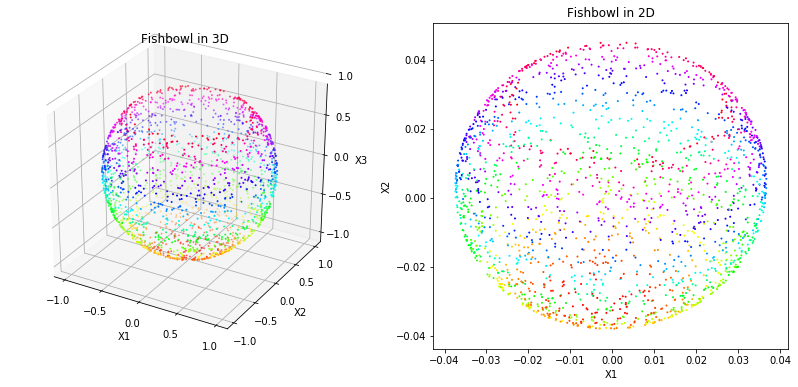

In [166]:
#plot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt



fig = plt.figure(figsize=(14,6))

# `ax` is a 3D-aware axis instance because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(xs=fishbowl_data.T[0],ys=fishbowl_data.T[1],zs=fishbowl_data.T[2],s=1, c=fishbowl_ref,cmap='hsv')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')

ax.set_xticks([-1,-0.5,0,0.5,1])
ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_zticks([-1,-0.5,0,0.5,1])
ax.set_title('Fishbowl in 3D')

ax = fig.add_subplot(1, 2, 2)
ax.scatter(x=fishbowl_lle.T[0],y=fishbowl_lle.T[1],s=1, c=fishbowl_ref,cmap='hsv')

ax.set_xlabel('X1')
ax.set_ylabel('X2')

ax.set_title('Fishbowl in 2D') #I think this should be a circle (with infinite data points)

In [173]:
#SWISSROLL
#apply lle
swissroll_lle=lle(swissroll_data,2,0.00001,'knn',k=35)

Text(0.5, 1.0, 'Swissroll in 2D')

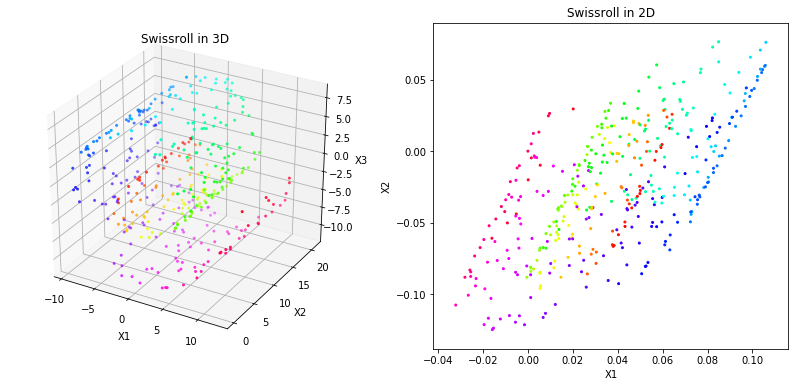

In [174]:
#plot

fig = plt.figure(figsize=(14,6))

# `ax` is a 3D-aware axis instance because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(xs=swissroll_data.T[0],ys=swissroll_data.T[1],zs=swissroll_data.T[2],s=4, c=swissroll_ref,cmap='hsv')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')

#ax.set_xticks([-1,-0.5,0,0.5,1])
#ax.set_yticks([-1,-0.5,0,0.5,1])
#ax.set_zticks([-1,-0.5,0,0.5,1])
ax.set_title('Swissroll in 3D')

ax = fig.add_subplot(1, 2, 2)
ax.scatter(x=swissroll_lle.T[0],y=swissroll_lle.T[1],s=4, c=swissroll_ref,cmap='hsv')

ax.set_xlabel('X1')
ax.set_ylabel('X2')

ax.set_title('Swissroll in 2D') #I think this should be a rectangle (with infinite data points)

In [ ]:
#FLATROLL
#apply lle
flatroll_lle=lle(flatroll_data,1,0.00001,'eps-ball',epsilon=11)

In [ ]:
#plot

fig = plt.figure(figsize=(14,6))

# `ax` is a 3D-aware axis instance because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(1, 2, 1)
ax.scatter(x=flatroll_data.T[0],y=flatroll_data.T[1],s=3, c=flatroll_data.T[0],cmap='hsv')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
#ax.set_xticks([-1,-0.5,0,0.5,1])
#ax.set_yticks([-1,-0.5,0,0.5,1])
#ax.set_zticks([-1,-0.5,0,0.5,1])
ax.set_title('Flatroll in 2D')

ax = fig.add_subplot(1, 2, 2)
y=np.zeros((len(flatroll_data),))
ax.scatter(x=flatroll_lle.T,y=y,s=3, c=flatroll_data.T[0],cmap='hsv')

ax.set_xlabel('X1')
ax.set_ylabel('X2')

ax.set_title('Flatroll in 2D') #I think this should be a line. (correct)